# Compute Low Dimensional Affinities

Computation:
$$(1+\|y_i - y_j\|^2)^{-1} \quad \forall i,j$$

Including all from above plus the computation of t-Student distribution plus the sum of the all normalization factor.
* adds: $5 N (N-1)/2$
* muls: $2 N (N-1)/2$
* divs: $N (N-1)/2$
* total: $4 N (N-1)$

Same memory traffic and the operational intensity will be (with $D=2$):
$$W = 4 N (N-1) ~ flops \approx 4 N^2 ~ flops$$
The memory traffic is computed taking into account that there is warm cache (on the previous step the whole input matrix have been accessed so it should be in cache):
$$Q = 4 \cdot N * N$$

Hence, the operational intesity will be:
$$I \approxeq \frac{4 N^2}{4 N^2} = 1$$

The computation will be **memory bound**.

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from visualization import plot

mpl.rcParams['figure.figsize'] = (8.1, 5)
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams['font.family'] = 'Roboto'
mpl.rcParams['font.size'] = 15

Cache sizes and limits taking into account that the working set is:
$$W_{set} = N \cdot D + 2 N^2$$

In [3]:
cache_1 = 32 * 2**10    # 32 KB
cache_2 = 256 * 2**10   # 256 KB
cache_3 = 8 * 2**20.    # 8 MB


N_cache1 = np.sqrt(cache_1 / 4 / 2)
N_cache2 = np.sqrt(cache_2 / 4 / 2)
N_cache3 = np.sqrt(cache_3 / 4 / 2)
print(f"Cache 1 limit size: {N_cache1}")
print(f"Cache 2 limit size: {N_cache2}")
print(f"Cache 3 limit size: {N_cache3}")

Cache 1 limit size: 64.0
Cache 2 limit size: 181.01933598375618
Cache 3 limit size: 1024.0


## System Information

CPU: Intel Core i7-6820HQ @ 2.70GHz

Cache:
* L1 Cache: 32 KB
* L2 Cache: 256 KB
* L3 Cache: 8 MB

Compiler:
`g++-4.9 (Homebrew GCC 4.9.4) 4.9.4`

## Final Benchmark

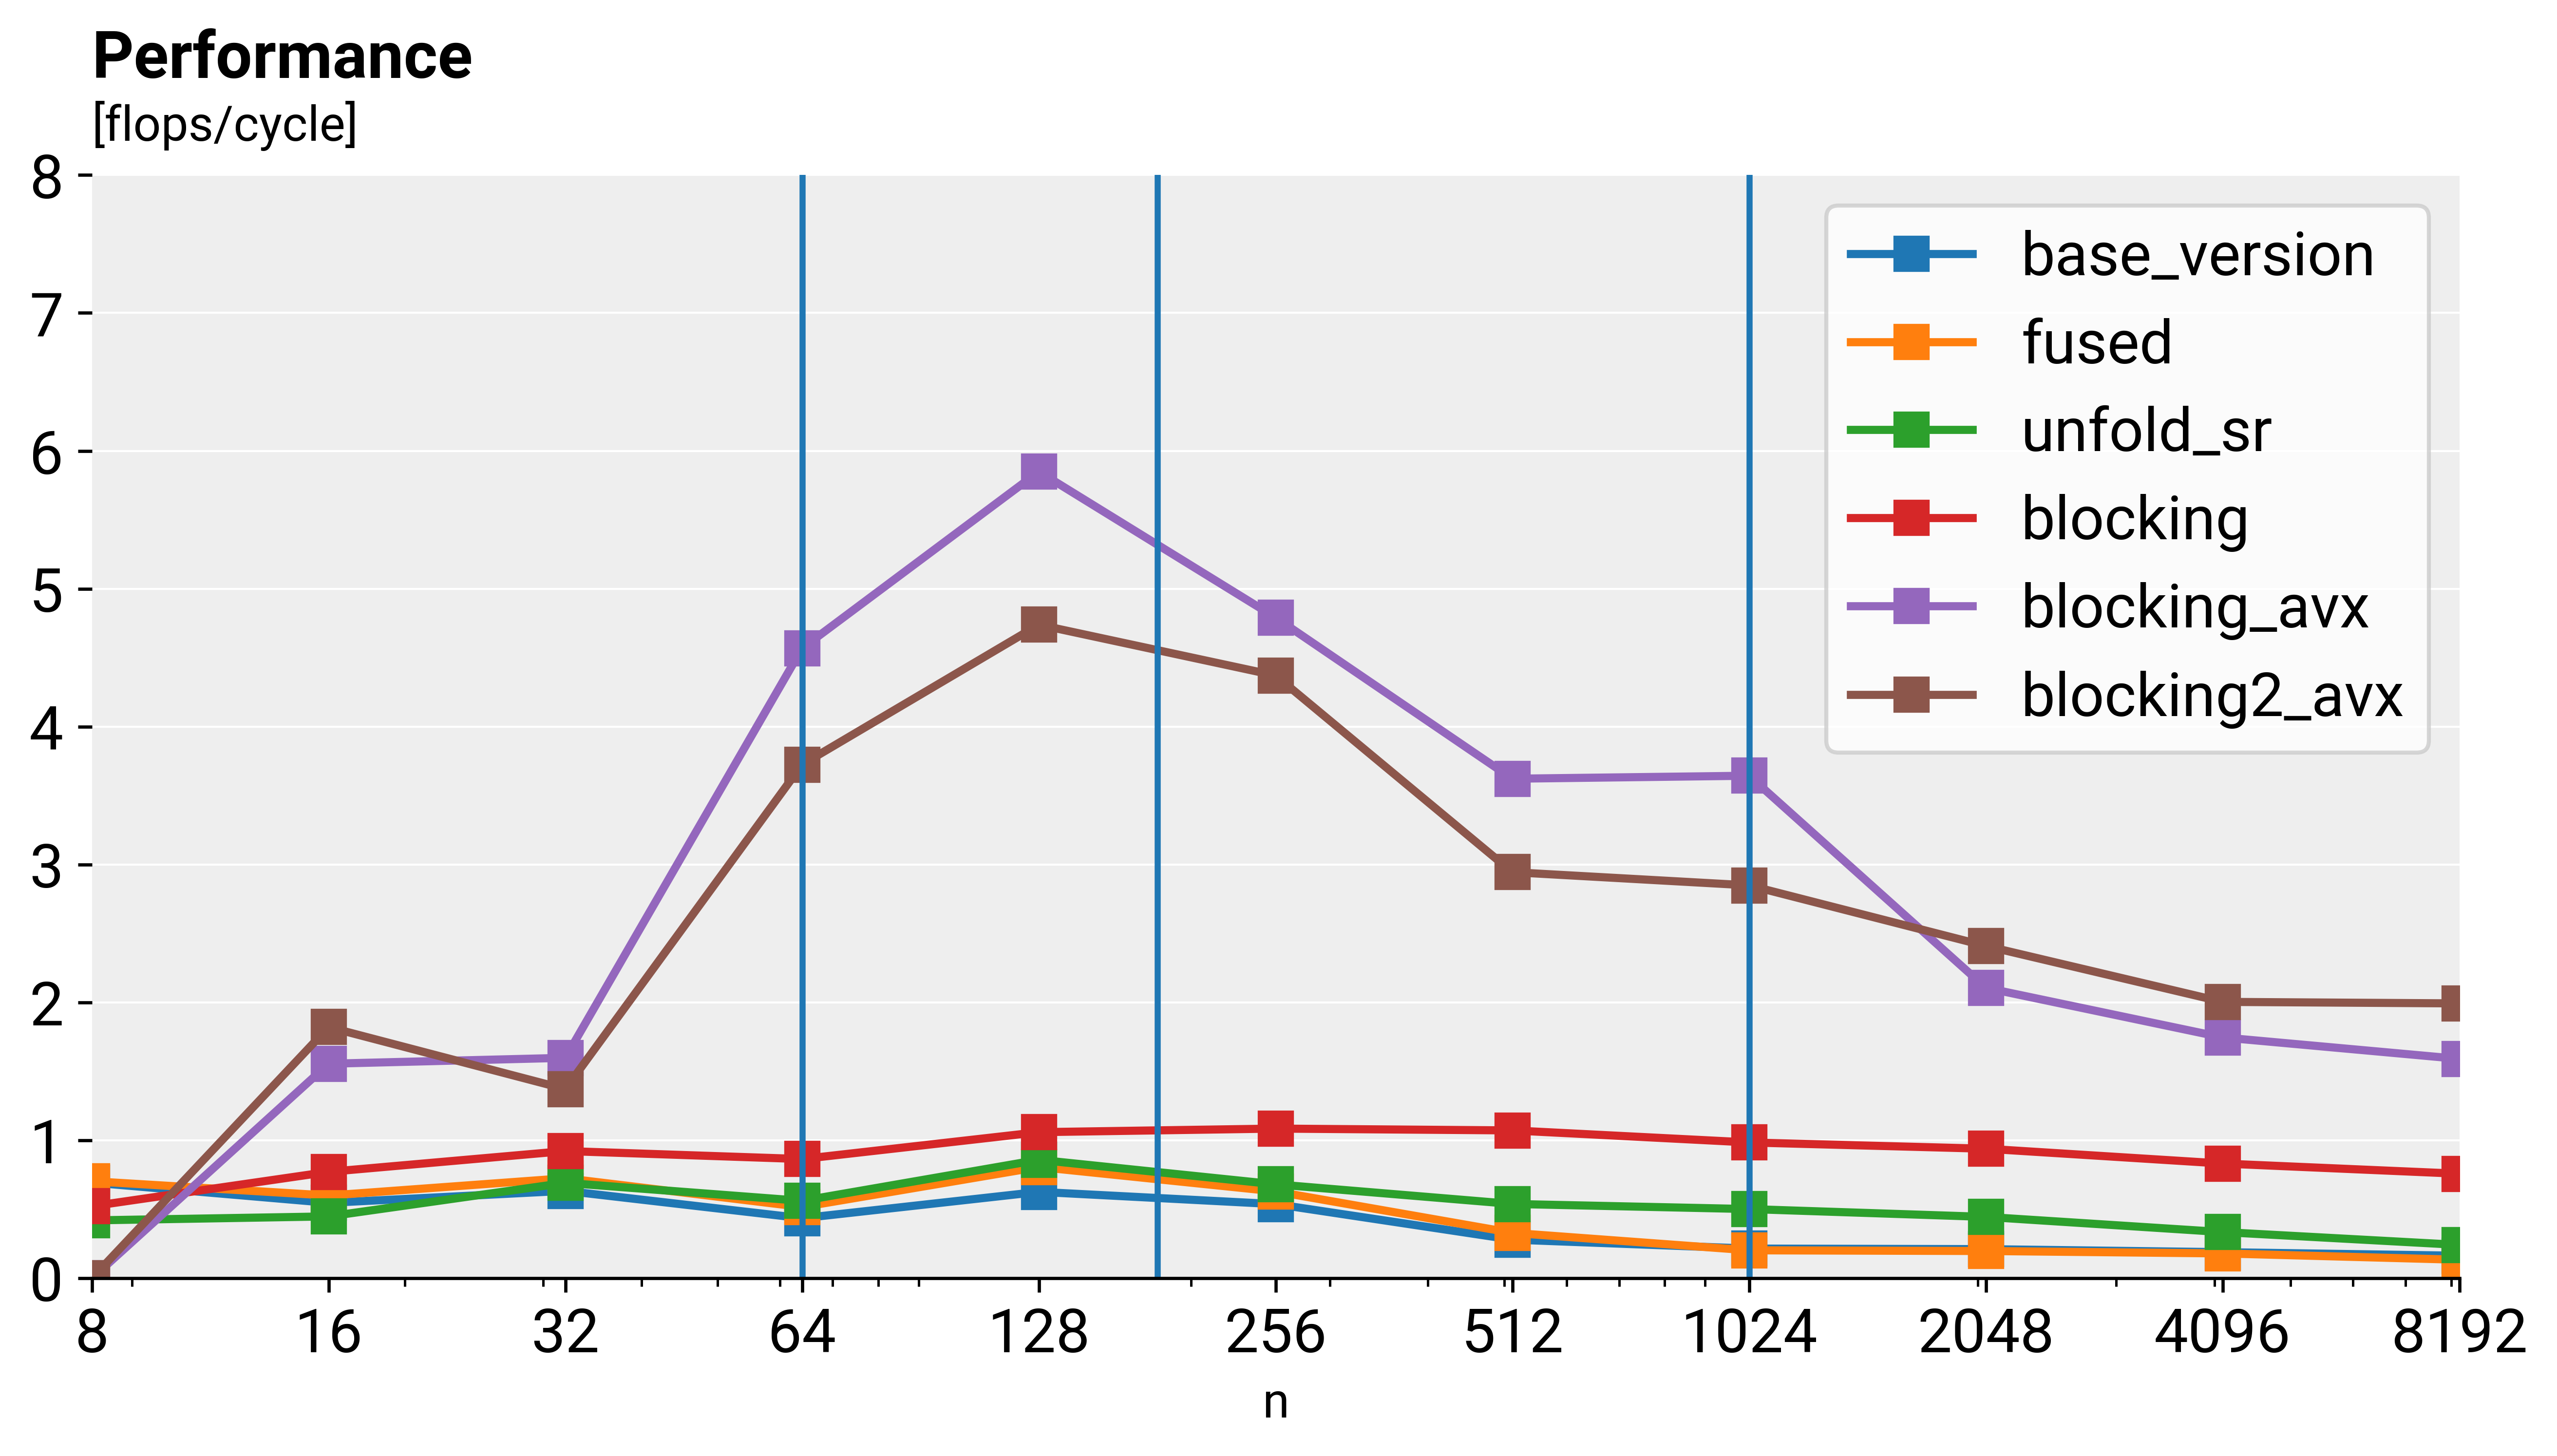

In [6]:
data = pd.read_csv("./bench_final_1.csv")
# Extract the input size
N = data["N"].as_matrix()
# Decompose the data frame into the different functions and compute the performance
func_names = data.columns.values[1:]
perf = []
flops = {
    "base_version": 5/2 * N * (N - 1) + 3 * N**2,
    "fused": 8/2 * N * (N - 1),
    "unfold_sr": 8/2 * N * (N - 1),
    "blocking": 8/2 * N * (N - 1),
    "blocking_avx": N/8*(N/8-1)/2 * (16*8 + 8*8 + 8*8*2 + 8*8 + 8*8 + 8*8),
    "blocking2_avx": N/8*(N/8-1)/2 * (16*8 + 8*8 + 8*8*2 + 8*8 + 8*8 + 8*8),
}

for func in func_names:
    cycles = data[func].as_matrix()
    P = flops[func] / cycles
    perf.append(P)
perf = np.array(perf)

ax = plot(N, perf, labels=func_names, ylim=8, title="Performance")
ax.set_xscale("log")
ax.set_xticks(N)
ax.set_xticklabels(N)
ax.axvline(N_cache1)
ax.axvline(N_cache2)
ax.axvline(N_cache3)
plt.show()

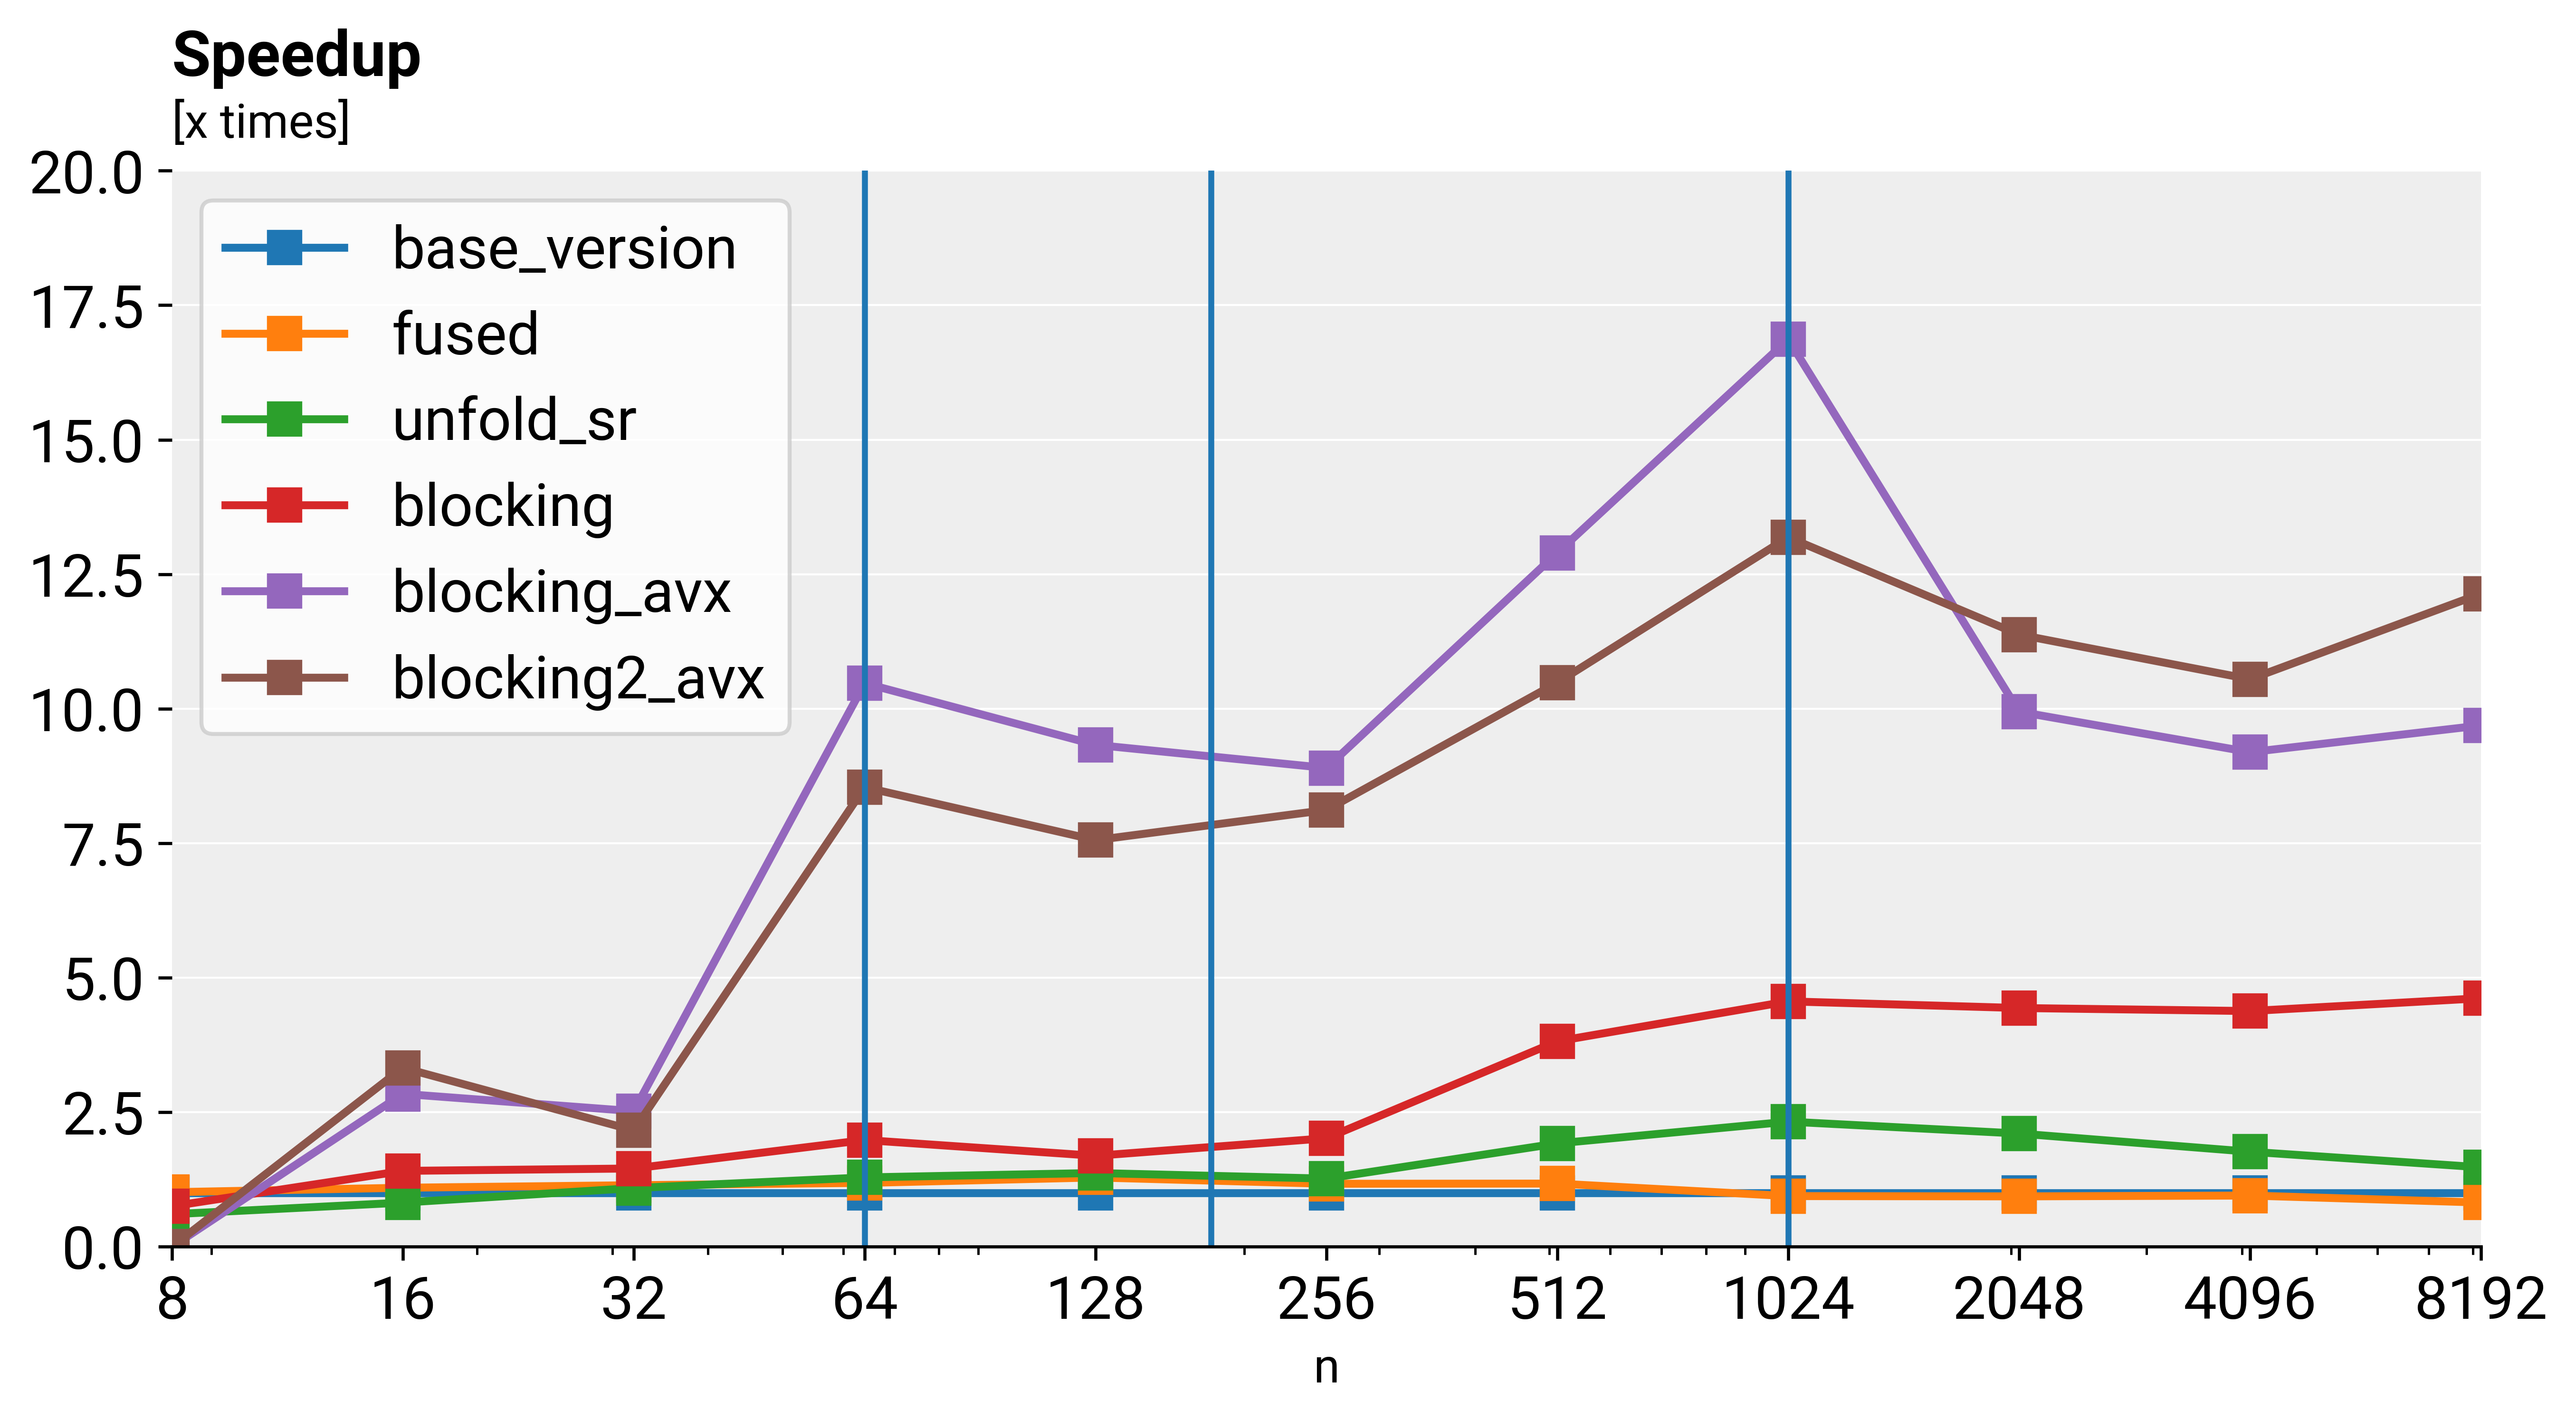

In [7]:
speedup = perf / perf[0,:]
ax = plot(N, speedup, labels=func_names, ylim=20, title="Speedup", ylabel="x times")
ax.set_xscale("log")
ax.set_xticks(N)
ax.set_xticklabels(N)
ax.axvline(N_cache1)
ax.axvline(N_cache2)
ax.axvline(N_cache3)
plt.show()

# Euler

### System Information

Compiler:
```
gcc (GCC) 4.9.2
```

CPU: **Intel Xeon E3-1285Lv5 Skylake 3.00 GHz**

Cache:
* L1: 32 KB
* L2: 256 KB
* L3: 8 MB

Memory bandwidth: 34.1 GB/s (theoretical)

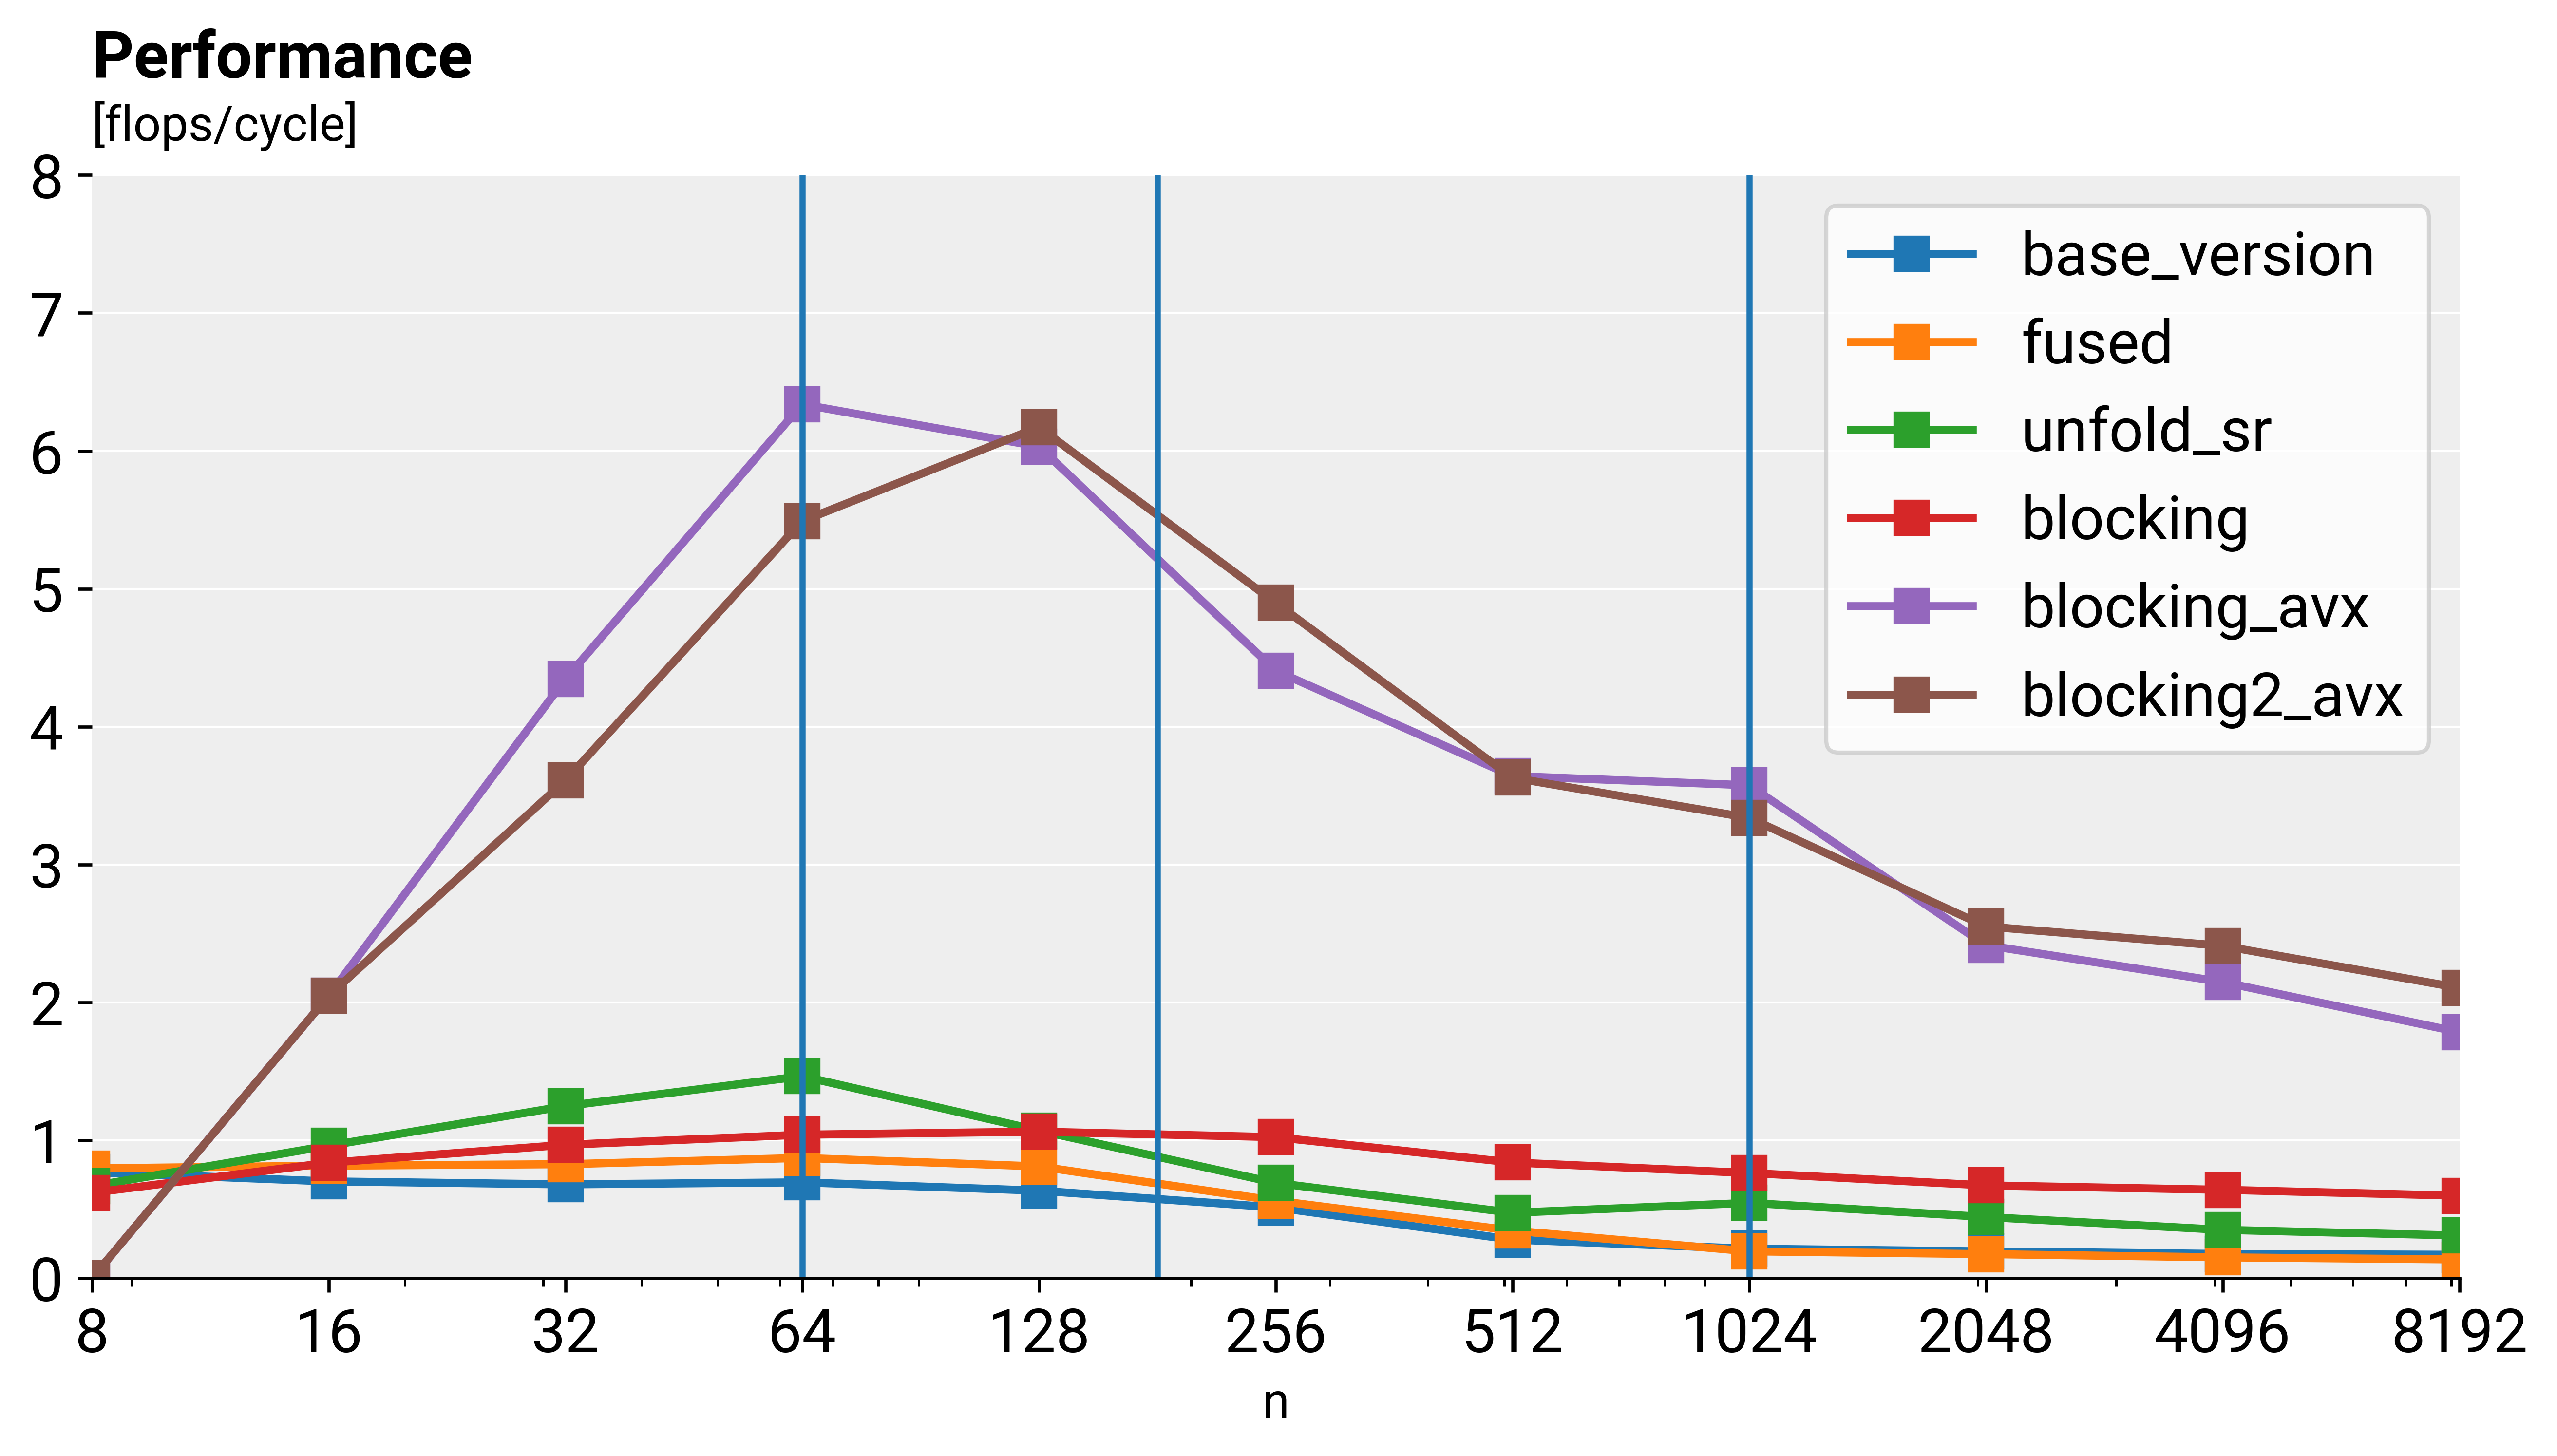

In [5]:
data = pd.read_csv("./euler/bench_2n.csv")
# Extract the input size
N = data["N"].as_matrix()
# Decompose the data frame into the different functions and compute the performance
func_names = data.columns.values[1:]
perf = []
cycles = []
flops = {
    "base_version": 5/2 * N * (N - 1) + 3 * N**2,
    "fused": 8/2 * N * (N - 1),
    "unfold_sr": 8/2 * N * (N - 1),
    "blocking": 8/2 * N * (N - 1),
    "blocking_avx": N/8*(N/8-1)/2 * (16*8 + 8*8 + 8*8*2 + 8*8 + 8*8 + 8*8),
    "blocking2_avx": N/8*(N/8-1)/2 * (16*8 + 8*8 + 8*8*2 + 8*8 + 8*8 + 8*8),
}

for func in func_names:
    cy = data[func].as_matrix()
    P = flops[func] / cy
    perf.append(P)
    cycles.append(cy)
    
perf = np.array(perf)
cycles = np.array(cycles)

ax = plot(N, perf, labels=func_names, ylim=8, title="Performance")
ax.set_xscale("log")
ax.set_xticks(N)
ax.set_xticklabels(N)
ax.axvline(N_cache1)
ax.axvline(N_cache2)
ax.axvline(N_cache3)
plt.show()

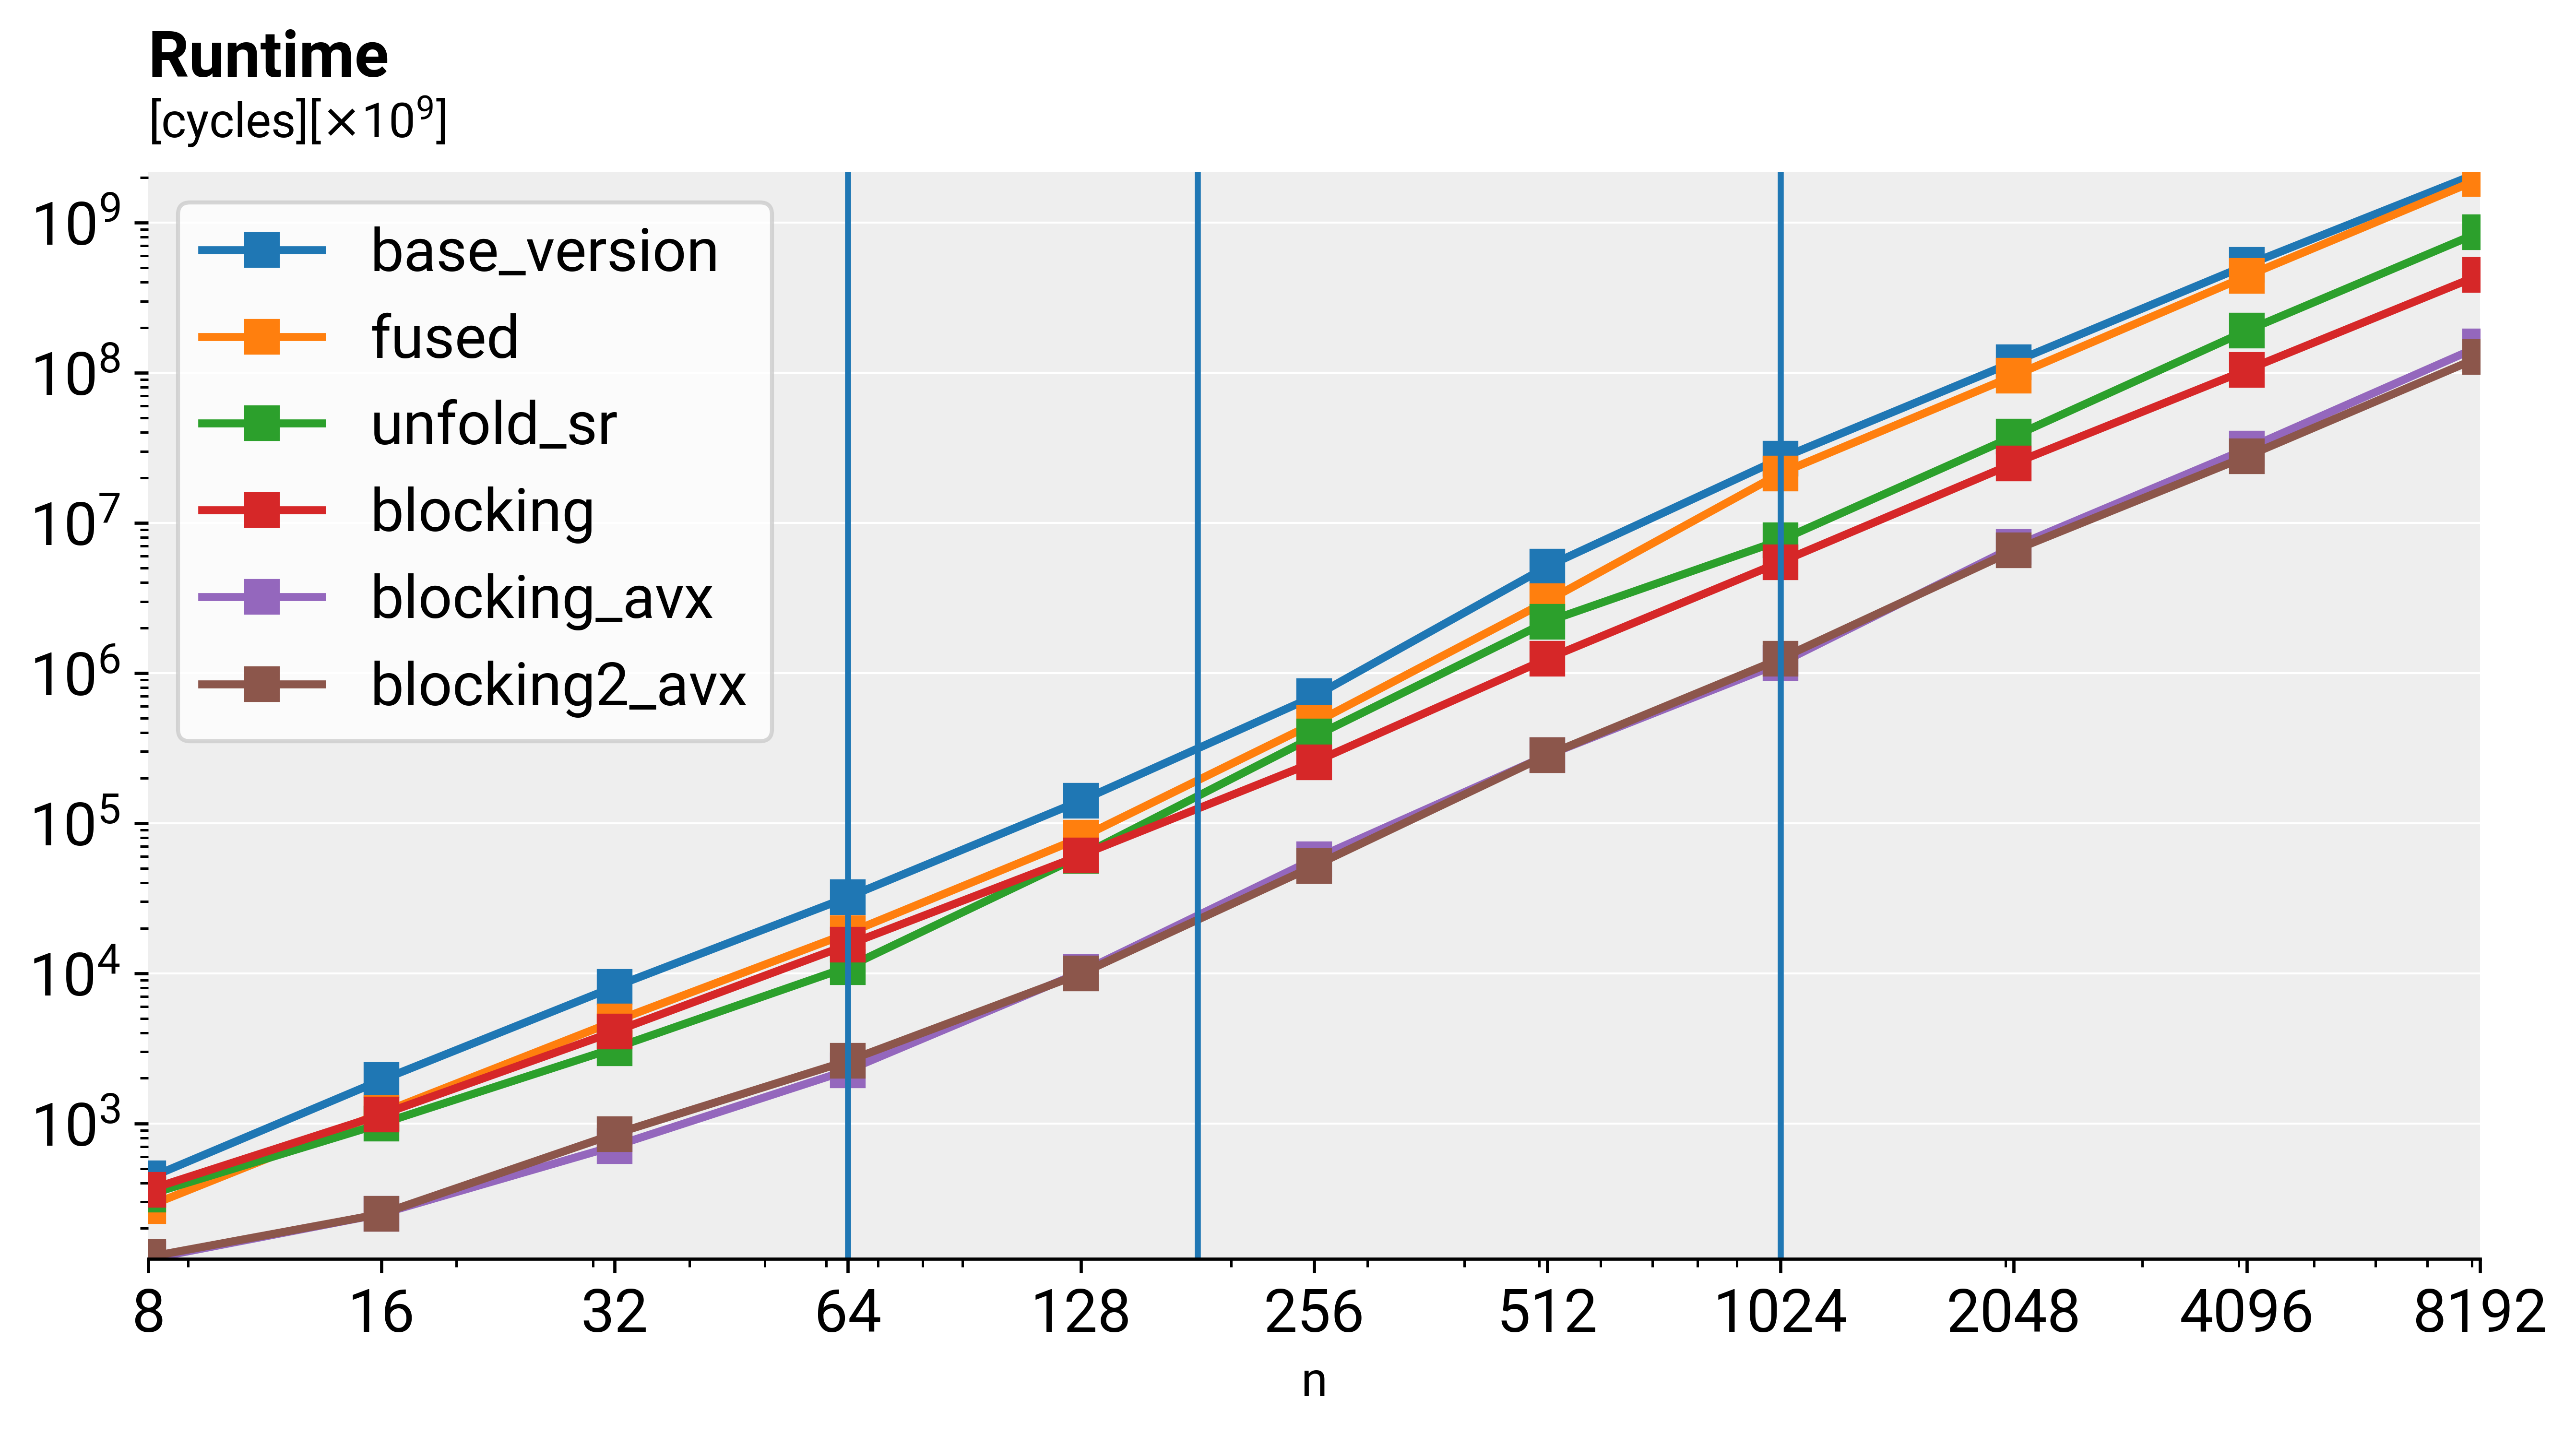

In [11]:
ax = plot(N, cycles, labels=func_names, ylim=cycles.max(), title="Runtime", ylabel="cycles")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([None, cycles.max()])
ax.set_xticks(N)
ax.set_xticklabels(N)
ax.axvline(N_cache1)
ax.axvline(N_cache2)
ax.axvline(N_cache3)
plt.show()

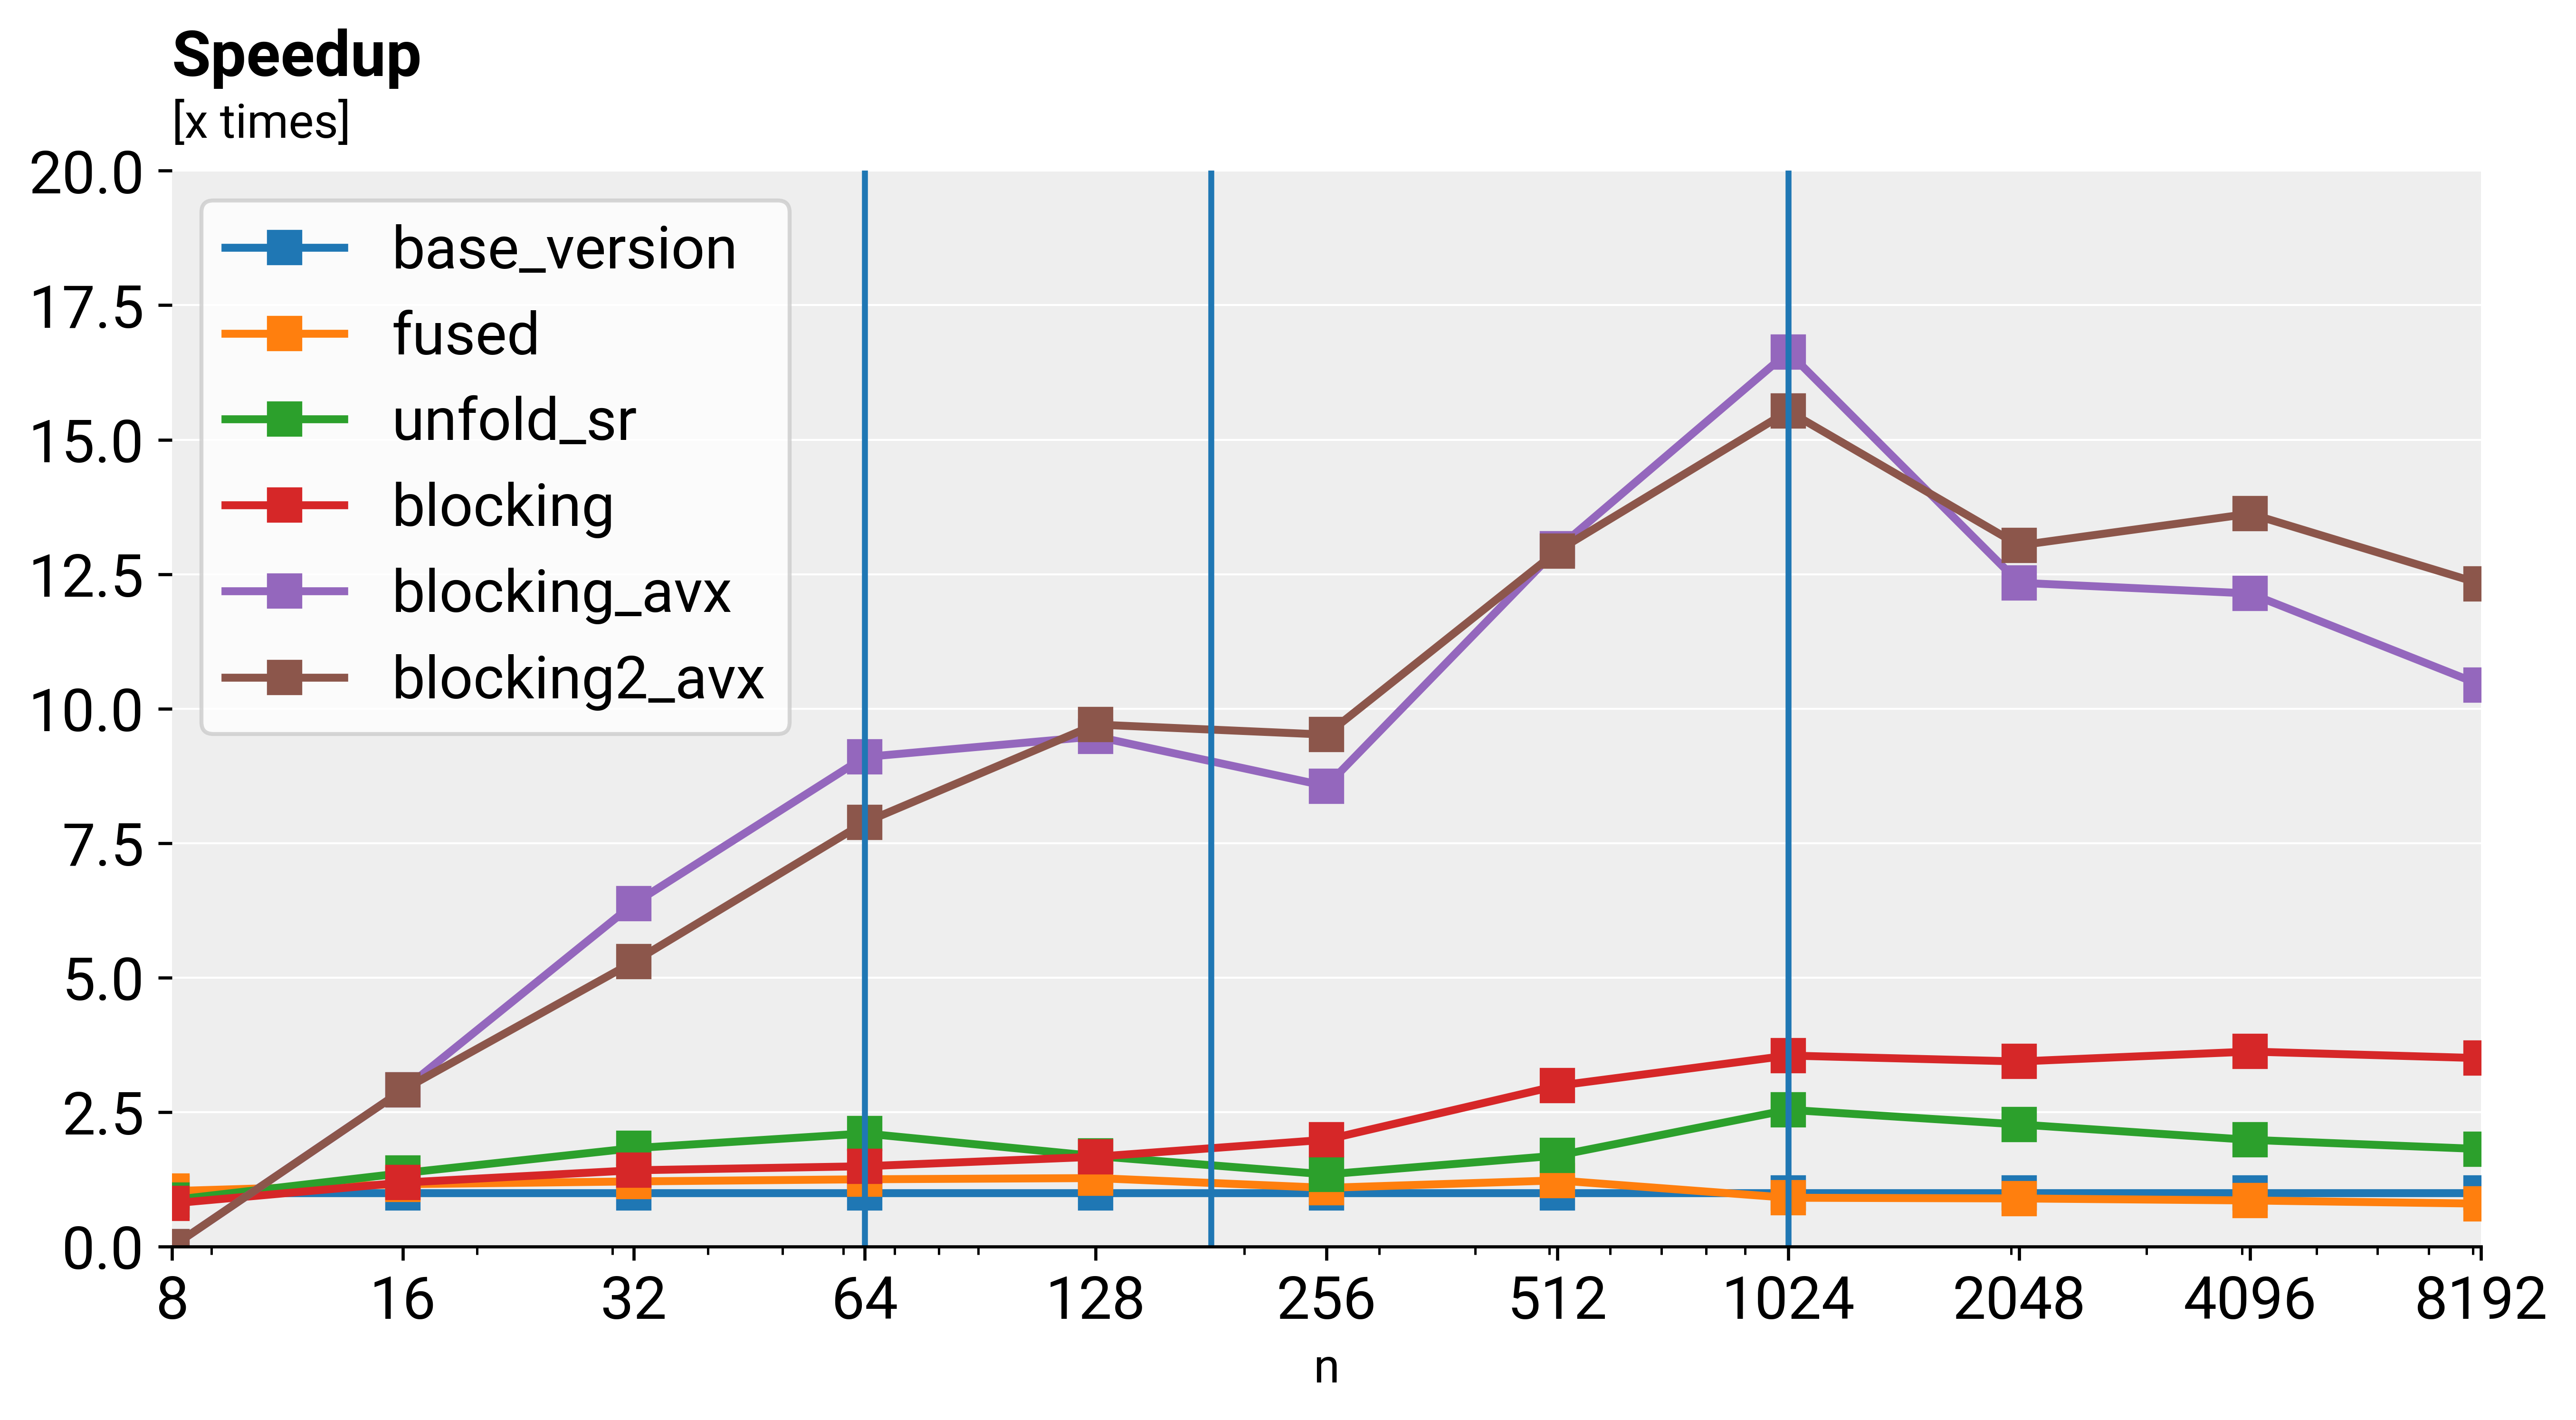

In [13]:
speedup = perf / perf[0]
ax = plot(N, speedup, labels=func_names, ylim=20, title="Speedup", ylabel="x times")
ax.set_xscale("log")
ax.set_xticks(N)
ax.set_xticklabels(N)
ax.axvline(N_cache1)
ax.axvline(N_cache2)
ax.axvline(N_cache3)
plt.show()

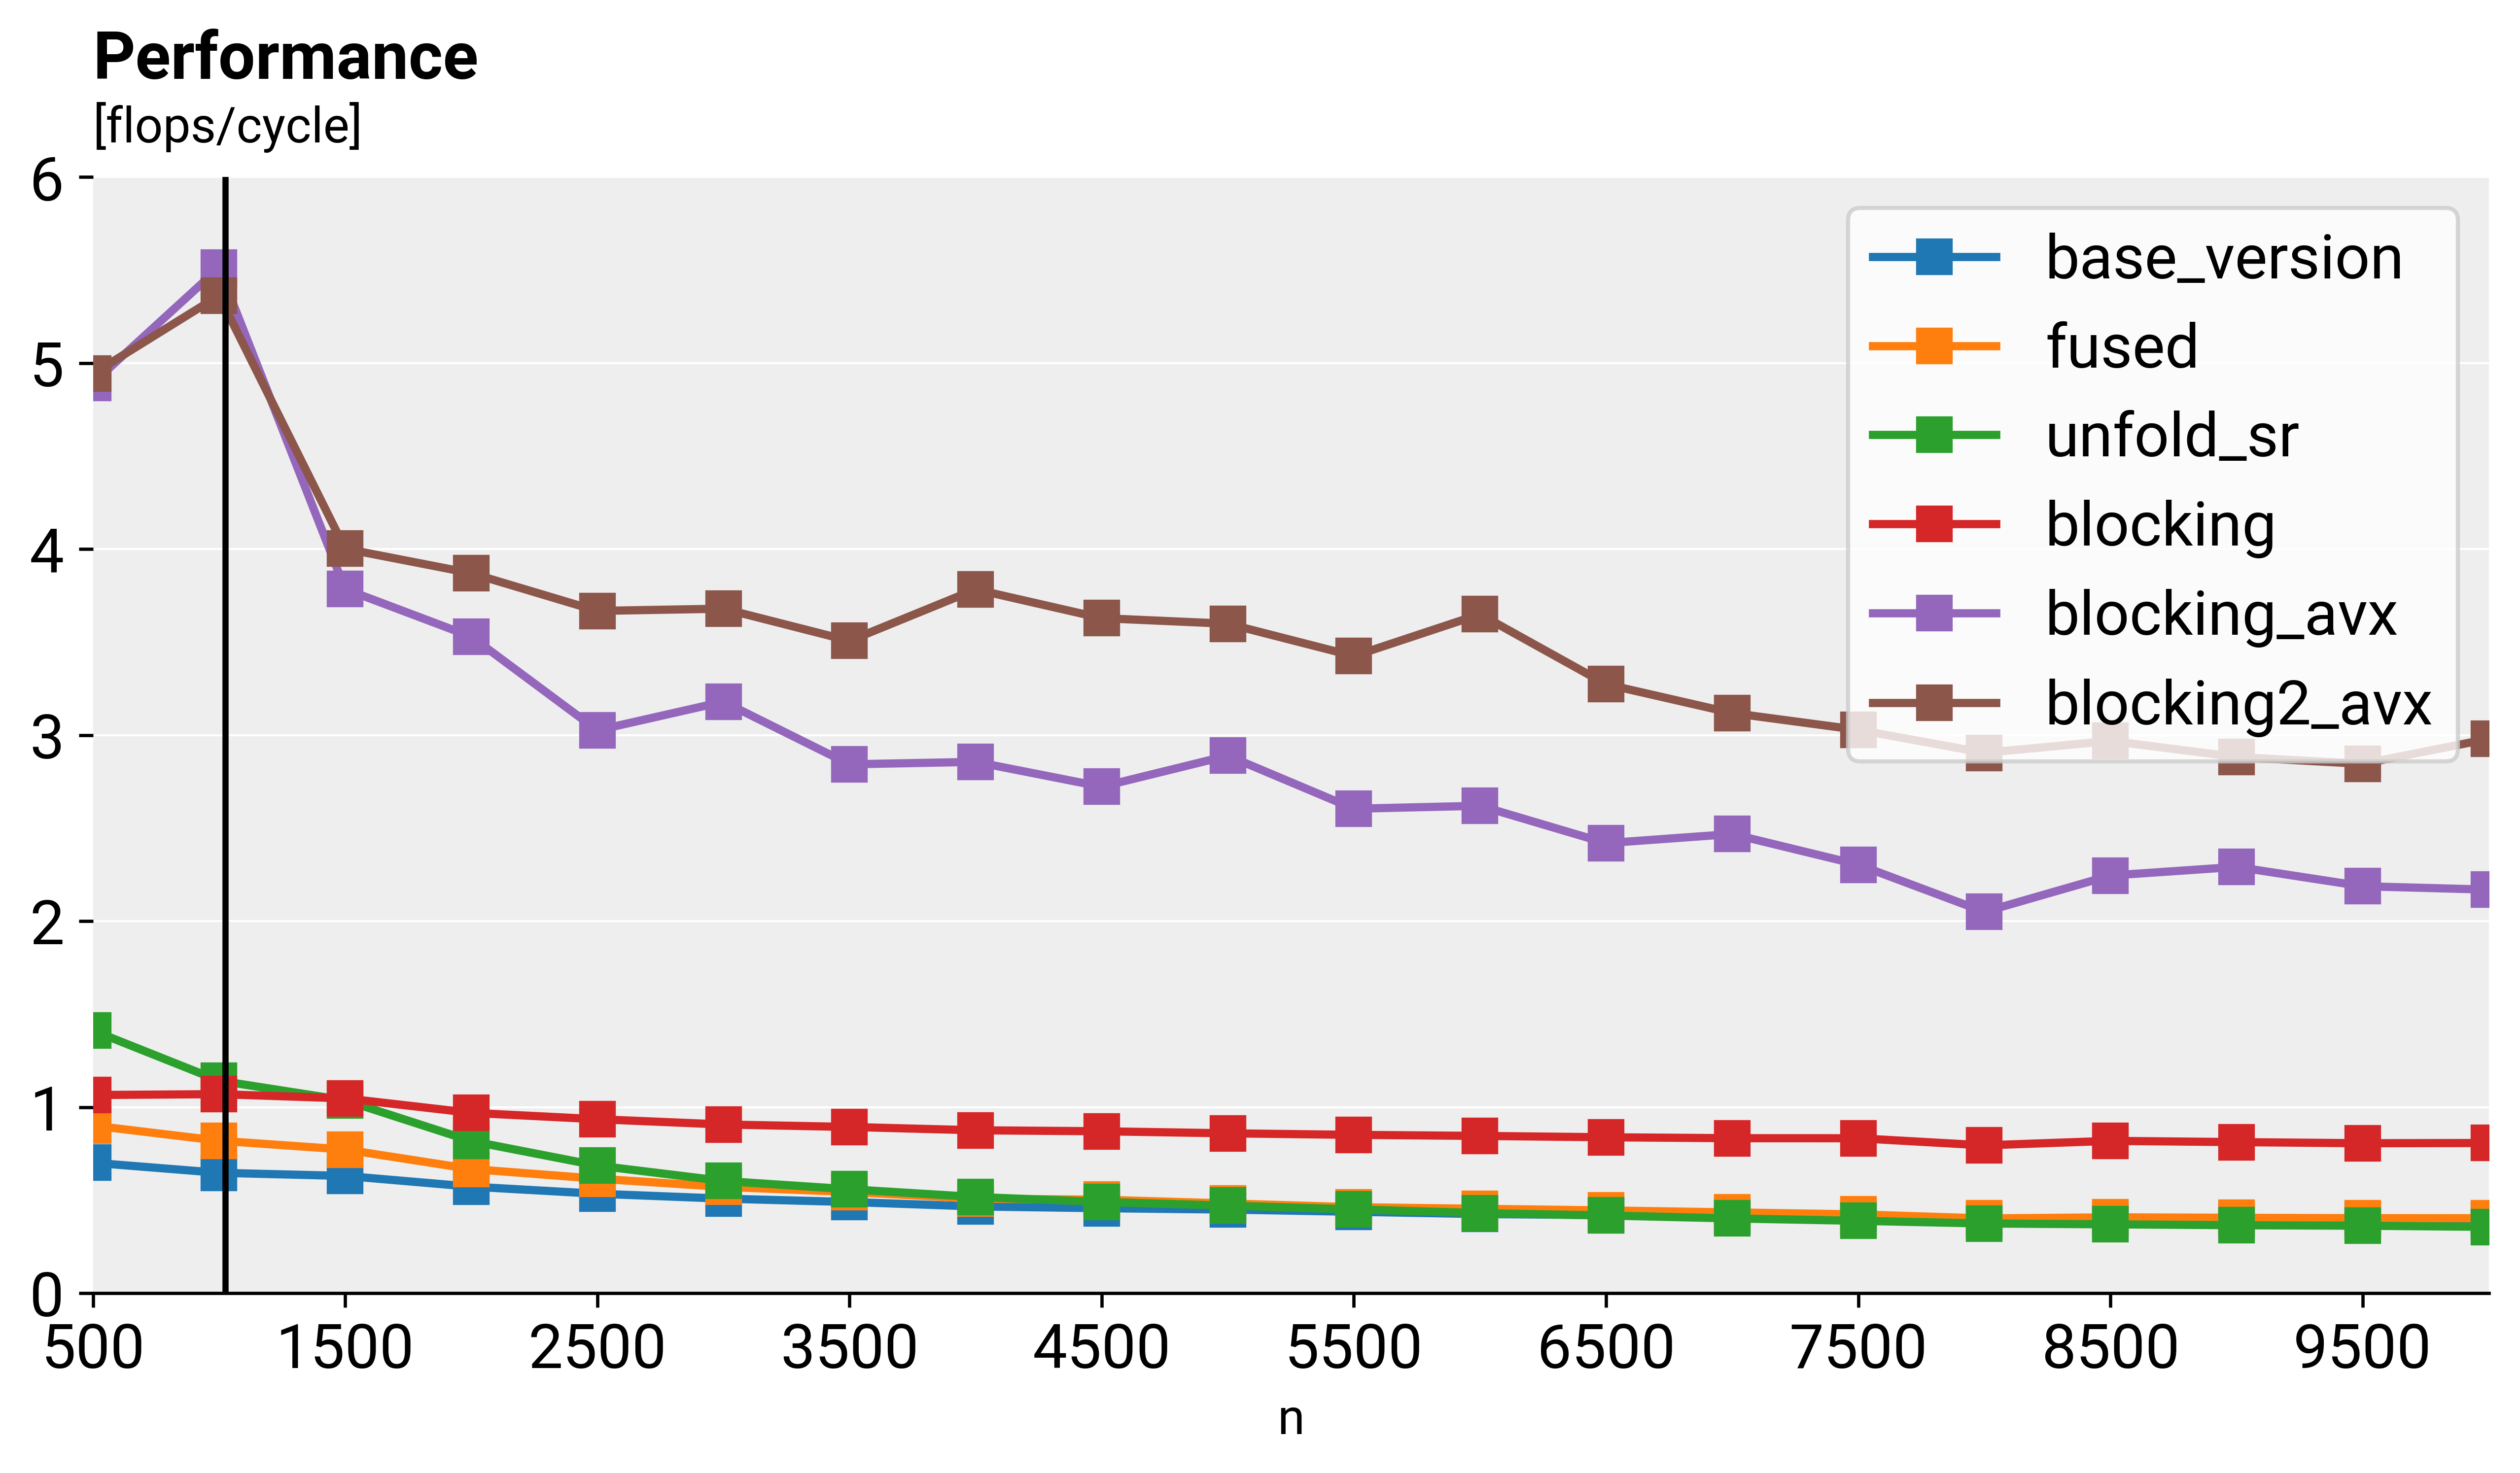

In [22]:
data = pd.read_csv("./euler/bench.csv")
# Extract the input size
N = data["N"].as_matrix()
# Decompose the data frame into the different functions and compute the performance
func_names = data.columns.values[1:]
perf = []
cycles = []
flops = {
    "base_version": 5/2 * N * (N - 1) + 3 * N**2,
    "fused": 8/2 * N * (N - 1),
    "unfold_sr": 8/2 * N * (N - 1),
    "blocking": 8/2 * N * (N - 1),
    "blocking_avx": N/8*(N/8-1)/2 * (16*8 + 8*8 + 8*8*2 + 8*8 + 8*8 + 8*8),
    "blocking2_avx": N/8*(N/8-1)/2 * (16*8 + 8*8 + 8*8*2 + 8*8 + 8*8 + 8*8),
}

for func in func_names:
    cy = data[func].as_matrix()
    P = flops[func] / cy
    perf.append(P)
    cycles.append(cy)
    
perf = np.array(perf)
cycles = np.array(cycles)

ax = plot(N, perf, labels=func_names, ylim=6, title="Performance")
ax.set_xticks(np.arange(N.min(), N.max()+1, 1000))
ax.set_xticklabels(np.arange(N.min(), N.max()+1, 1000))
ax.axvline(N_cache3, c="k")
plt.show()

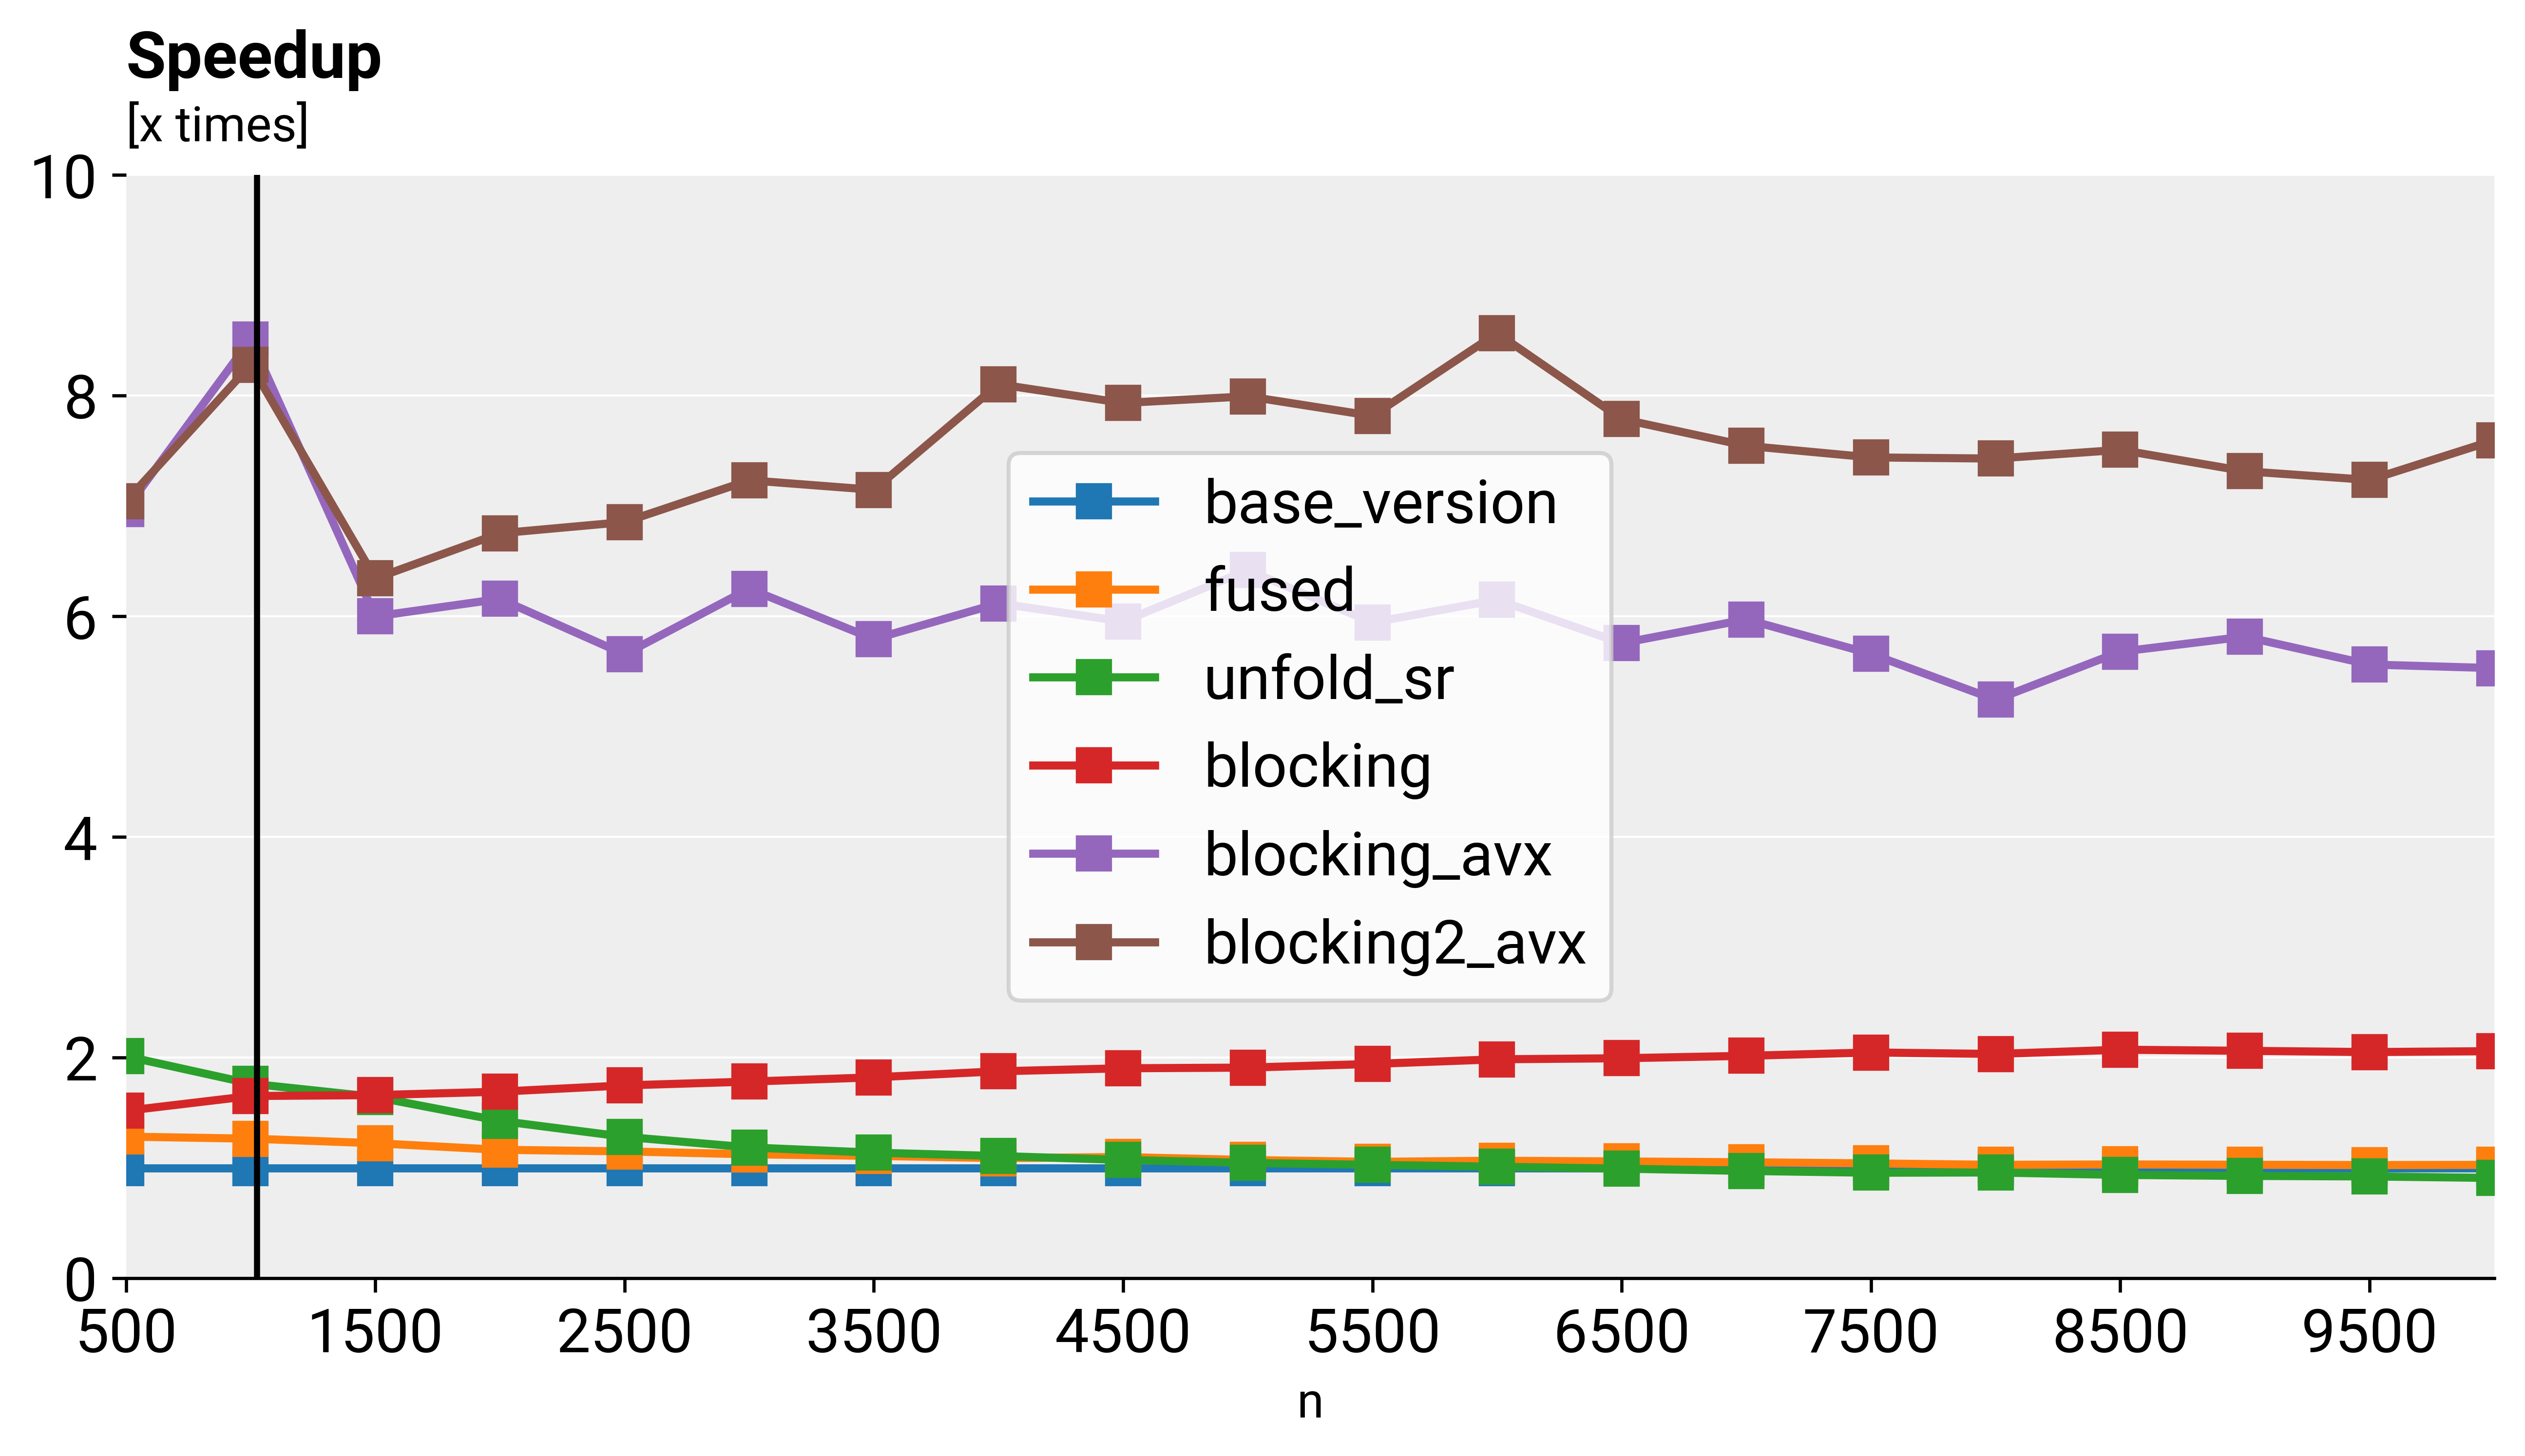

In [25]:
speedup = perf / perf[0]
ax = plot(N, speedup, labels=func_names, ylim=10, title="Speedup", ylabel="x times")
ax.set_xticks(np.arange(N.min(), N.max()+1, 1000))
ax.set_xticklabels(np.arange(N.min(), N.max()+1, 1000))
ax.axvline(N_cache3, c="k")
plt.show()